In [ ]:
from google.colab import drive
drive.mount('/GoogleDrive', force_remount=True)

Mounted at /GoogleDrive


In [ ]:
#!pip install torch==2.0.0
import pandas as pd
import torch
import numpy as np
from datetime import timedelta
from tqdm import tqdm
import os

os.environ['TORCH'] = torch.__version__

print("PyTorch has version {}".format(torch.__version__))

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html

!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html

!pip install torch-geometric

pt_version = torch.__version__
print(pt_version)

PyTorch has version 2.0.1+cu118
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 48.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 10.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=20005265e5b49ecb91f7a3d10371cc9793491dc63ea68fc581c16d0bf44413c3
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric
2.0.1+cu118


In [ ]:
from torch_geometric.data import InMemoryDataset, Data
from shutil import copyfile


def distance_to_weight(W, sigma2=0.1, epsilon=0.9, gat_version=False):
    """"
    Given distances between all nodes, convert into a weight matrix
    :param W distances
    :param sigma2 User configurable parameter to adjust sparsity of matrix
    :param epsilon User configurable parameter to adjust sparsity of matrix
    :param gat_version If true, use 0/1 weights with self loops. Otherwise, use float
    """
    n = W.shape[0]
    W = W / 10.
    W2, W_mask = W * W, np.ones([n, n]) - np.identity(n)
    # refer to Eq.10
    W = np.exp(-W2 / sigma2) * (np.exp(-W2 / sigma2) >= epsilon) * W_mask

    # If using the gat version of this, round to 0/1 and include self loops
    if gat_version:
        W[W>0] = 1
        W += np.identity(n)

    return W

class TrafficDataset(InMemoryDataset):
    """
    Dataset for Graph Neural Networks.
    """
    def __init__(self, config, root='', transform=None, pre_transform=None):
        self.config = config
        #self.W = W
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [os.path.join(self.raw_dir, '/GoogleDrive/My Drive/Colab Notebooks/datasets/bike_data_new.csv')]
        #'/GoogleDrive/My Drive/Colab Notebooks/datasets/PeMSD7_V_2283.csv'
    @property
    def processed_file_names(self):
        return ['/GoogleDrive/My Drive/Colab Notebooks/datasets/taxitesttimeseriesweather.pt']
        #'/GoogleDrive/My Drive/Colab Notebooks/datasets/taxitesttimeseries.pt'
    def download(self):
        pass
        #copyfile('/GoogleDrive/My Drive/Colab Notebooks/datasets/bike_data_new.csv', os.path.join(self.raw_dir, '/GoogleDrive/My Drive/Colab Notebooks/datasets/bike_data_new.csv'))
        #'/GoogleDrive/My Drive/Colab Notebooks/datasets/PeMSD7_V_2283.csv'
    def process(self):
        """
        Process the raw datasets into saved .pt dataset for later use.
        Note that any self.fields here wont exist if loading straight from the .pt file
        """
        # Data Preprocessing and loading
        data = pd.read_csv(self.raw_file_names[0], header=None).values
        holidays = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/timeseries.csv').values
        weather = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/weather.csv').values

        data = z_score(data, np.mean(data), np.std(data))
        n_window = self.config['N_PRED'] + self.config['SHIFT'] +  self.config['N_HIST']

        sequences = []
        #print("before loop")
        # T x F x N
        for i in range(self.config['N_DAYS']):
            if i%100 == 0:
              print("done with" + str(i))
            for j in range(self.config['N_SLOT']):
                # for each time point construct a different graph with data object
                # Docs here: https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data
                g = Data()

                sta = i * self.config['N_DAY_SLOT'] + j
                end = sta + n_window

                full_window = np.swapaxes(data[sta:end, :], 0, 1)
                full_window_holidays = np.swapaxes(holidays[sta:end, :], 0, 1)
                full_window_weather = np.swapaxes(weather[sta:end, :], 0, 1)
                g.x = torch.FloatTensor(full_window[:, 0:self.config['N_HIST']])
                g.timeseries = full_window_holidays[:, self.config['N_HIST']-1]
                g.weather = full_window_weather[:, self.config['N_HIST']-1]
                g.y = torch.FloatTensor(full_window[:, self.config['N_HIST']+self.config['SHIFT']:])
                sequences += [g]

        # Make the actual dataset
        #print("done with loop")
        data, slices = self.collate(sequences)
        torch.save((data, slices), self.processed_paths[0],)

def get_splits(dataset: TrafficDataset, n_slot, splits):
    """
    Given the data, split it into random subsets of train, val, and test as given by splits
    :param dataset: TrafficDataset object to split
    :param n_slot: Number of possible sliding windows in a day
    :param splits: (train, val, test) ratios
    """
    split_train, split_val, _ = splits
    i = n_slot*split_train
    j = n_slot*split_val
    train = dataset[:i]
    val = dataset[i:i+j]
    test = dataset[i+j:]

    return train, val, test


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv


class ST_GAT(torch.nn.Module):
    """
    Spatio-Temporal Graph Attention Network as presented in https://ieeexplore.ieee.org/document/8903252
    """
    def __init__(self, in_channels, out_channels, n_nodes, heads=32, dropout=0.0): #32
        """
        Initialize the ST-GAT model
        :param in_channels Number of input channels
        :param out_channels Number of output channels
        :param n_nodes Number of nodes in the graph
        :param heads Number of attention heads to use in graph
        :param dropout Dropout probability on output of Graph Attention Network
        """
        super(ST_GAT, self).__init__()
        self.n_pred = out_channels
        self.heads = heads
        self.dropout = dropout
        self.n_nodes = n_nodes

        lstm1_hidden_size = 256 #256
        lstm2_hidden_size = 512 #512

        # single graph attentional layer with 8 attention heads
        self.gat = GATConv(in_channels=in_channels, out_channels=in_channels,
            heads=heads, dropout=0.1, concat=False)

        # add two LSTM layers
        self.lstm1 = torch.nn.LSTM(input_size=self.n_nodes, hidden_size=lstm1_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
        self.lstm2 = torch.nn.LSTM(input_size=lstm1_hidden_size, hidden_size=lstm2_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param) #xavier_uniform_



        self.linear = torch.nn.Linear(lstm2_hidden_size, self.n_nodes*self.n_pred)
        torch.nn.init.xavier_uniform_(self.linear.weight)

        self.timeseries = torch.nn.Linear(8,self.n_nodes)
        torch.nn.init.xavier_uniform_(self.timeseries.weight)

        self.fc = torch.nn.Linear(6, 4)

        torch.nn.init.xavier_uniform_(self.fc.weight)

        # fully-connected neural network
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(self.n_pred+2, 128), #+2
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.n_pred),
        )

        self.lstm3 = torch.nn.LSTM(input_size=6, hidden_size = self.n_nodes, num_layers=1)
        for name, param in self.lstm3.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)


    def forward(self, data, device):
        """
        Forward pass of the ST-GAT model
        :param data Data to make a pass on
        :param device Device to operate on
        """
        x = data.x
        t = np.array(data.timeseries)
        w = np.array(data.weather)

        # apply dropout
        if device == 'cpu':
            x = torch.FloatTensor(x)
            t = torch.FloatTensor(t)
            w = torch.FloatTensor(w)
        else:
            x = torch.cuda.FloatTensor(x)
            t = torch.cuda.FloatTensor(t)
            w = torch.cuda.FloatTensor(w)

        # gat layer
        x = self.gat(x, edge_index, edge_attr)

        # RNN: 2 LSTM
        # [batchsize*n_nodes, seq_length] -> [batch_size, n_nodes, seq_length]
        batch_size = data.num_graphs
        n_node = int(data.num_nodes/batch_size)
        x = torch.reshape(x, (batch_size, n_node, data.num_features))
        # for lstm: x should be (seq_length, batch_size, n_nodes)
        # sequence length = 12, batch_size = 50, n_node = 258
        x = torch.movedim(x, 2, 0)
        # [12, 50, 258] -> [12, 50, 256]
        x, _ = self.lstm1(x)
        # [12, 50, 256] -> [12, 50, 512]
        x, _ = self.lstm2(x)

        # Output contains h_t for each timestep, only the last one has all input's accounted for
        # [12, 50, 512] -> [50, 512]
        x = torch.squeeze(x[-1, :, :])
        # [50, 512] -> [50, 258*4]
        x = self.linear(x)

        t = self.timeseries(t)
        t = t.flatten().unsqueeze(-1)

        w, _ = self.lstm3(w)
        w = w.flatten().unsqueeze(-1)

        # Now reshape into final output
        s = x.shape
        # [50, 258*4] -> [50, 258, 4]
        x = torch.reshape(x, (s[0], self.n_nodes, self.n_pred))

        # [50, 258, 4] ->  [12900, 4]
        x = torch.reshape(x, (s[0]*self.n_nodes, self.n_pred))

        # Bring the three modules together
        x3 = torch.cat([x,t,w], dim = 1)
        x3 = self.linear_relu_stack(x3)

        return x3


In [ ]:
@torch.no_grad()
def eval(model, device, dataloader, type=''):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param type Name of evaluation type, e.g. Train/Val/Test
    """
    model.eval()
    model.to(device)


    """rmse1 = 0
    rmse2 = 0
    rmse3 = 0
    rmse4 = 0
    rmse5 = 0
    rmse6 = 0
    rmse7 = 0
    rmse8 = 0"""
    rmse = 0
    mae = 0
    quant = 0
    n = 0

    # Evaluate model on all data
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch, device)
            truth = batch.y.view(pred.shape)
            if i == 0:
                y_pred = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
                y_truth = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])

            truth = un_z_score(truth, mean, std_dev)
            pred = un_z_score(pred, mean, std_dev)
            y_pred[i, :pred.shape[0], :] = pred
            y_truth[i, :pred.shape[0], :] = truth

            tensors = torch.split(truth, 1, dim=1)
            tensors2 = torch.split(pred, 1, dim=1)
            rmse += RMSE(truth, pred)
            mae += MAE(truth, pred)
            quant += UPE(truth,pred)

            """truth0 = tensors[0]
            truth1 = tensors[1]
            truth2 = tensors[2]
            truth3 = tensors[3]
            truth4 = tensors[4]
            truth5 = tensors[5]
            truth6 = tensors[6]
            truth7 = tensors[7]

            pred0 = tensors2[0]
            pred1 = tensors2[1]
            pred2 = tensors2[2]
            pred3 = tensors2[3]
            pred4 = tensors2[4]
            pred5 = tensors2[5]
            pred6 = tensors2[6]
            pred7 = tensors2[7]


            rmse1 += RMSE(truth0, pred0)
            rmse2 += RMSE(truth1, pred1)
            rmse3 += RMSE(truth2, pred2)
            rmse4 += RMSE(truth3, pred3)
            rmse5 += RMSE(truth4, pred4)
            rmse6 += RMSE(truth5, pred5)
            rmse7 += RMSE(truth6, pred6)
            rmse8 += RMSE(truth7, pred7)"""
            n += 1

    #rmse1, rmse2, rmse3, rmse4, rmse, mae, quant = rmse1 / n, rmse2 / n, rmse3 / n, rmse4/n, rmse/n, mae/n, quant/n
    #rmse1, rmse2, rmse3, rmse4,rmse5,rmse6,rmse7,rmse8, rmse, mae, quant = rmse1 / n, rmse2 / n, rmse3 / n, rmse4/n,rmse5/n,rmse6/n,rmse7/n,rmse8/n, rmse/n, mae/n, quant/n
    #print(f'{type}, RMSE1: {rmse1}, RMSE2: {rmse2}, RMSE3: {rmse3}, RMSE4: {rmse4}, RMSE5: {rmse5},RMSE6: {rmse6},RMSE7: {rmse7},RMSE8: {rmse8},RMSE:{rmse} , MAE:{mae}, UPE:{quant} ')
    rmse, mae, quant =  rmse/n, mae/n, quant/n
    print(rmse)
    #get the average score for each metric in each batch
    return rmse, mae, quant,  y_pred, y_truth
    #return round(rmse1.item(),3), round(rmse2.item(),3), round(rmse3.item(),3),round(rmse4.item(),3),rmse, mae, quant,  y_pred, y_truth

def train(model, device, dataloader, optimizer, loss_fn, epoch, edge_index):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param optimizer Optimizer to use
    :param loss_fn Loss function
    :param epoch Current epoch
    """
    model.train()
    for _, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch}")):
        batch.edge_index = edge_index
        #print(batch)
        batch = batch.to(device)
        optimizer.zero_grad()
        y_pred = torch.squeeze(model(batch, device))
        loss = loss_fn()(y_pred.float(), torch.squeeze(batch.y).float())
        loss.backward()
        optimizer.step()

    return loss

In [ ]:
def z_score(x, mean, std):
    """
    Z-score normalization function: $z = (X - \mu) / \sigma $,
    where z is the z-score, X is the value of the element,
    $\mu$ is the population mean, and $\sigma$ is the standard deviation.
    :param x: torch array, input array to be normalized.
    :param mean: float, the value of mean.
    :param std: float, the value of standard deviation.
    :return: torch array, z-score normalized array.
    """
    return (x - mean) / std

def un_z_score(x_normed, mean, std):
    """
    Undo the Z-score calculation
    :param x_normed: torch array, input array to be un-normalized.
    :param mean: float, the value of mean.
    :param std: float, the value of standard deviation.
    """
    return x_normed * std  + mean


def MAPE(v, v_):
    """
    Mean absolute percentage error, given as a % (e.g. 99 -> 99%)
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, MAPE averages on all elements of input.
    """
    return torch.mean(torch.abs((v_ - v)) /(v + 1e-15) * 100)


def RMSE(v, v_):
    """
    Mean squared error.
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, RMSE averages on all elements of input.
    """
    return torch.sqrt(torch.mean((v_ - v) ** 2))


def MAE(v, v_):
    """
    Mean absolute error.
    :param v: torch array, ground truth.
    :param v_: torch array, prediction.
    :return: torch scalar, MAE averages on all elements of input.
    """
    return torch.mean(torch.abs(v_ - v))

def UPE(v, v_, penalty_factor=3):
    # Ensure input tensors are of the same shape
    assert v.shape == v_.shape, "Input tensors must be of the same shape"

    # Compute difference
    diff = v - v_

    # Apply penalty to the cases where prediction is less than ground truth
    diff[diff > 0] *= penalty_factor

    # Average difference as a simple measure
    mean_diff = torch.mean(torch.abs(diff))

    return mean_diff


In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm
import time
import os
import matplotlib.pyplot as plt


def model_train(train_dataloader, val_dataloader, config, device, edge_index):
    """
    Train the ST-GAT model. Evaluate on validation dataset as you go.
    :param train_dataloader Data loader of training dataset
    :param val_dataloader Dataloader of val dataset
    :param config configuration to use
    :param device Device to evaluate on
    """

    # Make the model. Each datapoint in the graph is 228x12: N x F (N = # nodes, F = time window)
    model = ST_GAT(in_channels=config['N_HIST'], out_channels=config['N_PRED'], n_nodes=config['N_NODE'], dropout=config['DROPOUT'])
    optimizer = optim.Adam(model.parameters(), lr=config['INITIAL_LR'], weight_decay=config['WEIGHT_DECAY'])
    #optimizer = optim.SGD(model.parameters(), lr=config['INITIAL_LR'], momentum=0.9, nesterov=True)
    #optimizer = optim.Adagrad(model.parameters(), lr=config['INITIAL_LR'], weight_decay=config['WEIGHT_DECAY'])
    #optimizer = optim.RMSprop(model.parameters(), lr=config['INITIAL_LR'], weight_decay=config['WEIGHT_DECAY'], momentum = 0.9)
    #optimizer = optim.Rprop(model.parameters(), lr=config['INITIAL_LR'])


    loss_fn = torch.nn.MSELoss

    model.to(device)

    losslist = []

    # For every epoch, train the model on training dataset. Evaluate model on validation dataset
    for epoch in range(config['EPOCHS']):
        loss = train(model, device, train_dataloader, optimizer, loss_fn, epoch, edge_index)
        losslist.append(loss)
        print(f"Loss: {loss:.3f}")
        if (epoch+1) % 10 == 0:
            eval(model, device, train_dataloader, 'Train')
            eval(model, device, val_dataloader, 'Valid')

    # Save the model
    timestr = time.strftime("%m-%d-%H%M%S")
    torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": losslist,
            }, os.path.join(config["CHECKPOINT_DIR"], f"model_{timestr}.pt"))

    return model

def model_test(model, test_dataloader, device, config):
    """
    Test the ST-GAT model
    :param test_dataloader Data loader of test dataset
    :param device Device to evaluate on
    """
    _, _, _, y_pred, y_truth = eval(model, device, test_dataloader, 'Test')


In [ ]:
# Constant config to use throughout
config = {
    'BATCH_SIZE': 128, #50
    'EPOCHS': 10, #60
    'WEIGHT_DECAY': 1e-5, #5e-5
    'INITIAL_LR': 1e-4, #3e-4
    'CHECKPOINT_DIR': '/GoogleDrive/My Drive/Colab Notebooks/datasets/runs',
    'N_PRED': 4,
    'SHIFT': 4,
    'N_HIST': 4,
    'DROPOUT': 0.1,
    # number of possible 15 minute measurements per day
    'N_DAY_SLOT': 96,
    # number of days worth of data in the dataset
    'N_DAYS': 2617, #2439 2617
    # If false, use GCN paper weight matrix, if true, use GAT paper weight matrix
    'USE_GAT_WEIGHTS': True,
    'N_NODE': 258 #258, 428
}

config['N_SLOT']= config['N_DAY_SLOT'] - (config['N_PRED']+config['SHIFT']+config['N_HIST']) + 1

In [ ]:
from torch_geometric.loader import DataLoader
import math
import random

# Number of possible windows in a day


# Load the weight and dataset dataset
#distances = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/PeMSD7_W_2283.csv', header=None).values
#W = distance_to_weight(distances, gat_version=config['USE_GAT_WEIGHTS'])
W = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/taxi_weights_30.csv', index_col=0).values
#W = pd.read_csv('/GoogleDrive/My Drive/Colab Notebooks/datasets/bike_weights_30.csv', index_col=0).values

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

dataset = TrafficDataset(config)


# total of 44 days in the dataset, use 34 for training, 5 for val, 5 for test
d_train, d_val, d_test = get_splits(dataset, config['N_SLOT'], (1826, 365, 426)) #1826 1648
#d_train, d_val, d_test = get_splits(dataset, config['N_SLOT'], (182, 36, 42)) #1826 1648


"""num_values_to_mask = round(config["N_HIST"] * config["N_NODE"] * 0.3)

for data in d_test:
    all_indices = torch.randperm(data.x.numel())
    mask_indices = all_indices[:num_values_to_mask]

    # get the flat view of x only once, to avoid calling view multiple times
    data_x_flat = data.x.view(-1)

    # update the values using vectorized operations
    data_x_flat[mask_indices] = 0"""



"""def generate_unique_random_values(n, k):
    if k > n:
        raise ValueError("k should be less than or equal to n")

    unique_values = set()
    while len(unique_values) < k:
        unique_values.add(random.randint(0, n-1))

    return list(unique_values)


def remove_nodes(adj_matrix, nodes_to_remove):
    adj_matrix[nodes_to_remove, :] = 0
    adj_matrix[:, nodes_to_remove] = 0
    return adj_matrix



test = generate_unique_random_values(config["N_NODE"], round(config["N_NODE"] * 0.99))

W = remove_nodes(W, test)"""

train_dataloader = DataLoader(d_train, batch_size=config['BATCH_SIZE'], shuffle=True)
val_dataloader = DataLoader(d_val, batch_size=config['BATCH_SIZE'], shuffle=True)
test_dataloader = DataLoader(d_test, batch_size=config['BATCH_SIZE'], shuffle=False)


edge_index = torch.zeros((2, config['N_NODE']**2), dtype=torch.long)
# create an edge_attr matrix with our weights  (num_edges x 1) --> our edge features are dim 1
edge_attr = torch.zeros((config['N_NODE']**2, 1))
num_edges = 0
for i in range(config['N_NODE']):
    for j in range(config['N_NODE']):
        if W[i, j] != 0.:
            edge_index[0, num_edges] = i
            edge_index[1, num_edges] = j
            edge_attr[num_edges] = W[i, j]
            num_edges += 1


# using resize_ to just keep the first num_edges entries
edge_index = edge_index.resize_(2, num_edges).to(device)
#print(edge_index.size())
edge_attr = edge_attr.resize_(num_edges, 1).to(device)


mean, std_dev =  2.6225484224593916, 10.46861919110906 # taxis: 2.6225484224593916, 10.46861919110906

# 0.21459733142892176, 0.9983478235701564 bike



Using cuda
TrafficDataset(31025)


In [ ]:
model = model_train(train_dataloader, val_dataloader, config, device, edge_index)

Epoch 0: 100%|██████████| 548/548 [00:26<00:00, 20.32it/s]


Loss: 0.581


Epoch 1: 100%|██████████| 548/548 [00:24<00:00, 22.15it/s]


Loss: 0.331


Epoch 2: 100%|██████████| 548/548 [00:24<00:00, 22.45it/s]


Loss: 0.379


Epoch 3: 100%|██████████| 548/548 [00:24<00:00, 22.41it/s]


Loss: 0.411


Epoch 4: 100%|██████████| 548/548 [00:24<00:00, 22.27it/s]


Loss: 0.439


Epoch 5: 100%|██████████| 548/548 [00:24<00:00, 22.32it/s]


Loss: 0.340


Epoch 6: 100%|██████████| 548/548 [00:25<00:00, 21.71it/s]


Loss: 0.502


Epoch 7: 100%|██████████| 548/548 [00:24<00:00, 22.37it/s]


Loss: 0.292


Epoch 8: 100%|██████████| 548/548 [00:24<00:00, 22.36it/s]


Loss: 0.197


Epoch 9: 100%|██████████| 548/548 [00:24<00:00, 22.36it/s]


Loss: 0.390
tensor(0.6208, device='cuda:0')
tensor(0.7274, device='cuda:0')


In [ ]:
checkpoint = torch.load("/GoogleDrive/My Drive/Colab Notebooks/datasets/runs/modelbesttaxifull_30epochs_128.pt")#,map_location=torch.device('cpu'))
#print(checkpoint["epoch"])

model1 = ST_GAT(in_channels=config['N_HIST'], out_channels=config['N_PRED'], n_nodes=config['N_NODE'], dropout=config['DROPOUT'])
model1.load_state_dict(checkpoint['model_state_dict'])

rms,mae,quant, y_pred, y_truth = eval(model1, device, test_dataloader, 'Test')

print(rms,mae,quant)


tensor(2.1634, device='cuda:0')
tensor(2.1634, device='cuda:0') tensor(0.6683, device='cuda:0') tensor(1.2033, device='cuda:0')


In [ ]:
def top10top5eval():
  top10 = [314, 363, 339, 360, 340, 361, 391, 313, 312, 292]#[87, 76, 183, 68, 78, 97, 84, 234, 71, 69]#[314, 363, 339, 360, 340, 361, 391, 313, 312, 292]
  rmselist = []
  upelist = []

  for i in top10:
    s = y_pred.shape
    y_pred1 = y_pred.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    y_pred2 = y_pred1[:, :, i, :]
    y_pred3 = torch.flatten(y_pred2)

    s = y_truth.shape
    y_truth1 = y_truth.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    y_truth2 = y_truth1[:, :, i, :]
    y_truth3 = torch.flatten(y_truth2)

    rmselist.append(RMSE(y_pred3,y_truth3).item())
    upelist.append(UPE(y_pred3,y_truth3).item())


  top10 = sum(rmselist)/10
  top5 = sum(rmselist[-5:])/5
  return round(top5,3), round(top10,3), round(sum(upelist[-5:])/5,3), round(sum(upelist)/10,3)

In [ ]:
print(top10top5eval())

(3.221, 2.916, 3.261, 2.972)


In [ ]:
#top50 bike stations: [239, 300, 320, 295, 233, 265, 268, 175, 146, 380, 263, 304, 294, 321, 317, 240, 303, 315, 144, 322, 291, 338, 316, 269, 319, 358, 343, 259, 366, 359, 344, 347, 383, 293, 357, 362, 342, 384, 364, 382, 314, 363, 339, 360, 340, 361, 391, 313, 312, 292]
# how much they make up of the total 0.5887405118802201

#top 50 taxi stations: [187, 179, 138, 108, 50, 67, 204, 257, 254, 231, 190, 106, 26, 107, 113, 47, 102, 105, 101, 121, 112, 140, 244, 72, 219, 77, 57, 22, 51, 60, 103, 139, 88, 91, 79, 239, 62, 73, 92, 65, 87, 76, 183, 68, 78, 97, 84, 234, 71, 69]
#how much they make up of the total 0.9004108620253742


def rmse50(y_pred, y_truth):
  top10 = [239, 300, 320, 295, 233, 265, 268, 175, 146, 380, 263, 304, 294, 321, 317, 240, 303, 315, 144, 322, 291, 338, 316, 269, 319, 358, 343, 259, 366, 359, 344, 347, 383, 293, 357, 362, 342, 384, 364, 382, 314, 363, 339, 360, 340, 361, 391, 313, 312, 292]
  rmse1 = 0
  s = y_pred.shape
  t = y_truth.shape

  for i in top10:
      pred = y_pred.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
      pred = torch.flatten(pred[:, :, i, :])

      truth = y_truth.reshape(t[0], config['BATCH_SIZE'], config['N_NODE'], t[-1])
      truth = torch.flatten(truth[:, :, i, :])
      rmse1 += RMSE(pred,truth).item()

  rmse1 = round(rmse1/50,3)

  return rmse1

In [ ]:
#top50 bike stations: [239, 300, 320, 295, 233, 265, 268, 175, 146, 380, 263, 304, 294, 321, 317, 240, 303, 315, 144, 322, 291, 338, 316, 269, 319, 358, 343, 259, 366, 359, 344, 347, 383, 293, 357, 362, 342, 384, 364, 382, 314, 363, 339, 360, 340, 361, 391, 313, 312, 292]
# how much they make up of the total 0.5887405118802201

#top 50 taxi stations: [187, 179, 138, 108, 50, 67, 204, 257, 254, 231, 190, 106, 26, 107, 113, 47, 102, 105, 101, 121, 112, 140, 244, 72, 219, 77, 57, 22, 51, 60, 103, 139, 88, 91, 79, 239, 62, 73, 92, 65, 87, 76, 183, 68, 78, 97, 84, 234, 71, 69]
#how much they make up of the total 0.9004108620253742


def upe50(y_pred, y_truth):
  top10 = [239, 300, 320, 295, 233, 265, 268, 175, 146, 380, 263, 304, 294, 321, 317, 240, 303, 315, 144, 322, 291, 338, 316, 269, 319, 358, 343, 259, 366, 359, 344, 347, 383, 293, 357, 362, 342, 384, 364, 382, 314, 363, 339, 360, 340, 361, 391, 313, 312, 292]
  rmse1 = 0
  s = y_pred.shape
  t = y_truth.shape

  for i in top10:
      pred = y_pred.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
      pred = torch.flatten(pred[:, :, i, :])

      truth = y_truth.reshape(t[0], config['BATCH_SIZE'], config['N_NODE'], t[-1])
      truth = torch.flatten(truth[:, :, i, :])
      rmse1 += UPE(pred,truth).item()

  rmse1 = round(rmse1/50,3)

  return rmse1

In [ ]:
print(rmse50(y_pred,y_truth))

1.648


In [ ]:
print(upe50(y_pred,y_truth))

1.76


In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def plot_prediction(test_dataloader, y_pred, y_truth, node, config, window,days):
    # Calculate the truth
    s = y_truth.shape
    y_truth = y_truth.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    # just get the first prediction out for the nth node
    y_truth = y_truth[:, :, node, window]
    # Flatten to get the predictions for entire test dataset
    y_truth = torch.flatten(y_truth)
    day0_truth = y_truth[(days[0]*config['N_SLOT']):(days[1]*config['N_SLOT'])]


    # Calculate the predicted
    s = y_pred.shape
    y_pred = y_pred.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    # just get the first prediction out for the nth node
    y_pred = y_pred[:, :, node, window]
    # Flatten to get the predictions for entire test dataset
    y_pred = torch.flatten(y_pred)
    # Just grab the first day
    day0_pred = y_pred[(days[0]*config['N_SLOT']):(days[1]*config['N_SLOT'])]
    extra = 8 * 15
    t = []

    for i in range((days[1]-days[0]) * config['N_SLOT']):
      if i % config['N_SLOT'] == 0 and i > 0:
        extra+= (config['N_PRED'] + config['N_HIST'] + config['SHIFT'] - 1) * 15
      val = days[0]*96*15 + 15 * (i+window) + extra
      t.append(val)

    start_date = datetime(2019, 1, 1)
    t_dates = [start_date + timedelta(minutes=minutes) for minutes in t]
    fig, ax = plt.subplots()

    # Plotting
    ax.plot(t_dates, day0_pred, label='ST-GAT')
    ax.plot(t_dates, day0_truth, label='truth')

    # Set x-axis to display dates in a nice format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    # Auto-rotate the x-axis labels
    fig.autofmt_xdate()

    ax.set_xlabel('Date and Time')
    ax.set_ylabel('Taxi demand prediction')

    ax.set_title('Predictions of Taxi Demand over Time')
    ax.legend()

    plt.title('Predictions of Taxi Bicycle over Time')
    plt.legend()
    plt.savefig('predicted_times.png')
    plt.show()

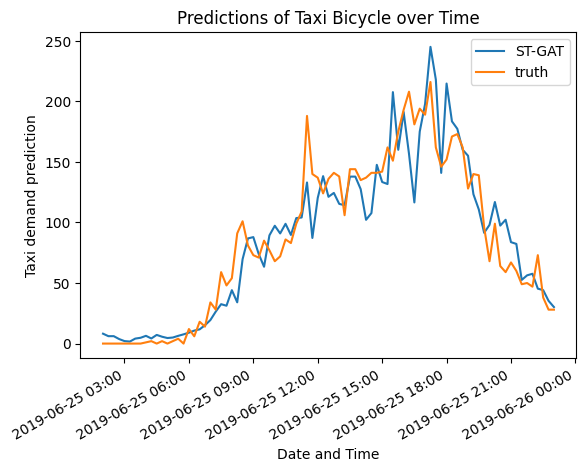

In [ ]:
plot_prediction(test_dataloader, y_pred, y_truth, 69, config, 0, [175,176]) #69, 71, 78, 84, 97 taxis
# bikes: 292, 312, 313


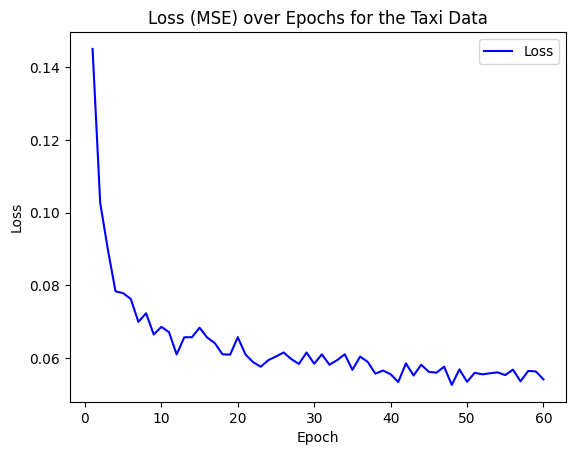

In [ ]:
import matplotlib.pyplot as plt
import torch

checkpoint = torch.load("/GoogleDrive/My Drive/Colab Notebooks/datasets/runs/modeltaxifull_60epochs_1024.pt",map_location=torch.device('cpu')) #60 runs: model_07-02-141615
losses = [i.item() for i in checkpoint["loss"]]

def plot_losses(losses):
    epochs = range(1, len(losses) + 1)

    plt.plot(epochs, losses, 'b', label='Loss')
    plt.title('Loss (MSE) over Epochs for the Taxi Data')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_losses(losses)